### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

### **Load Dataset**

In [2]:
df = pd.read_parquet("/workspaces/SentinelNet/data/DoS-Wednesday-no-metadata.parquet")

print("Dataset Shape:", df.shape)

print("\nDataset Head: \n")
print(df.head())

print("\nDataset info:\n")
print(df.info())

Dataset Shape: (584991, 78)

Dataset Head: 

   Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0         6          38308                  1                       1   
1         6            479                 11                       5   
2         6           1095                 10                       6   
3         6          15206                 17                      12   
4         6           1092                  9                       6   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                         6                         6                      6   
1                       172                       326                     79   
2                      3150                      3150                   1575   
3                      3452                      6660                   1313   
4                      3150                      3152                   1575   

   Fwd Packet Length Min  Fwd Packe

### **Data Cleaning**

In [3]:
# Check NaN and inf
print("NaN values:\n", df.isna().sum().sum())
print("Infinite values:\n", np.isinf(df.select_dtypes(include=[float, int])).sum().sum())

# Replace inf/-inf with NaN (if any)
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop or fill missing values if present
df.dropna(inplace=True)

# Count and remove duplicates
print("Duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

NaN values:
 0
Infinite values:
 0


Duplicate rows: 0


### **Verify Label Column Integrity**

In [4]:
print(df['Label'].value_counts())

df['Label'] = df['Label'].replace({
    'DoS Hulk': 'Attack',
    'DoS GoldenEye': 'Attack',
    'DoS Slowhttptest': 'Attack',
    'DoS slowloris': 'Attack',
    'Heartbleed' : 'Attack',
    'BENIGN': 'Benign'
})

# Encode labels numerically
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

print("Final shape:", df.shape)
print("Classes:", le.classes_)


Label
Benign              391235
DoS Hulk            172846
DoS GoldenEye        10286
DoS slowloris         5385
DoS Slowhttptest      5228
Heartbleed              11
Name: count, dtype: int64
Final shape: (584991, 78)
Classes: ['Attack' 'Benign']


/tmp/ipykernel_2780/3871018720.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Label'] = df['Label'].replace({


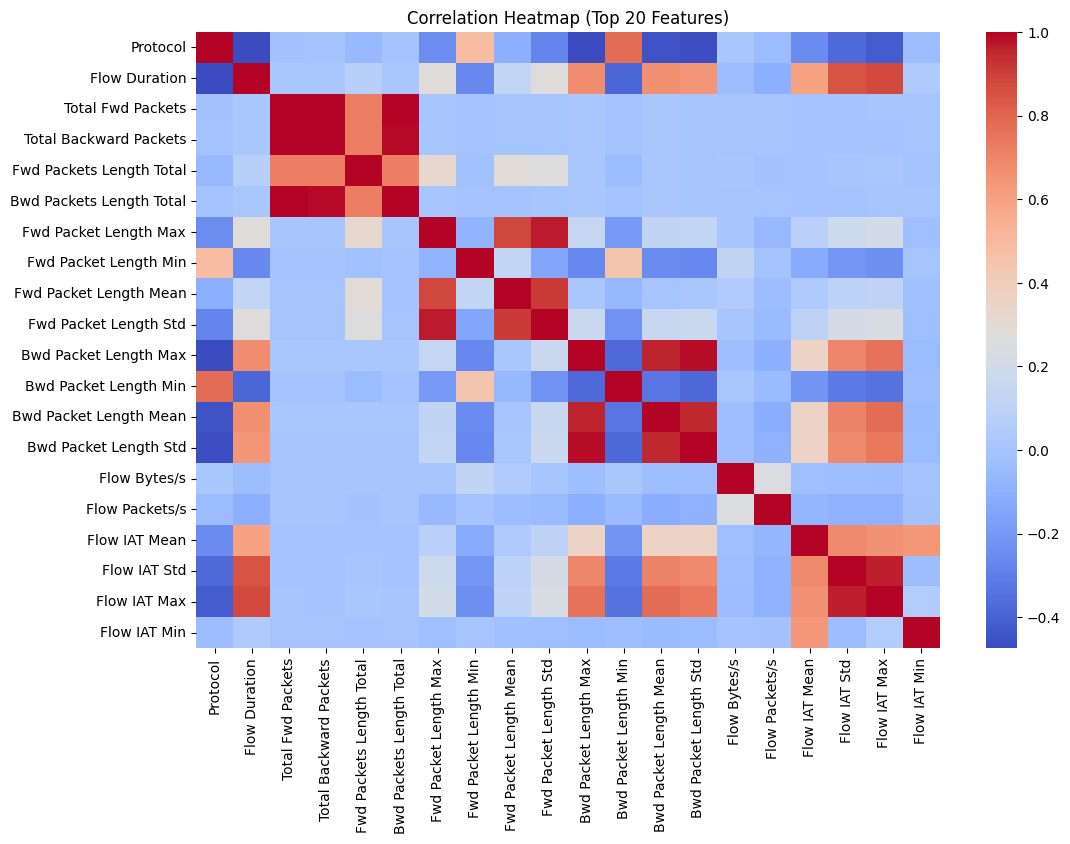

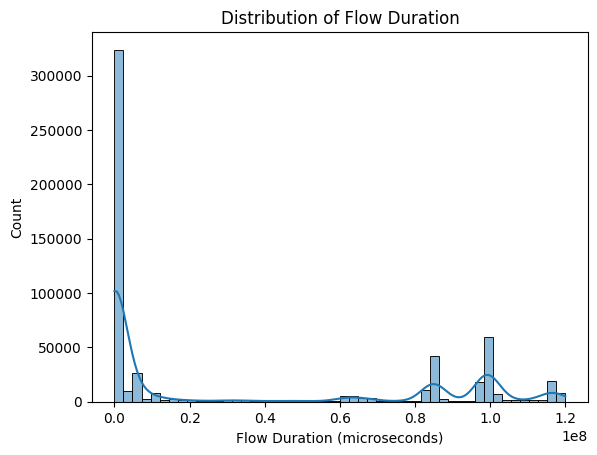

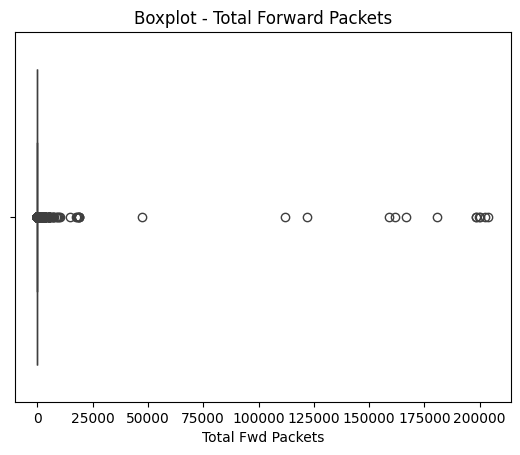

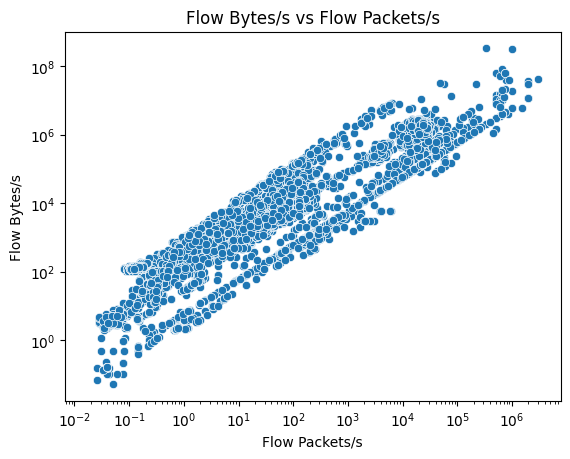

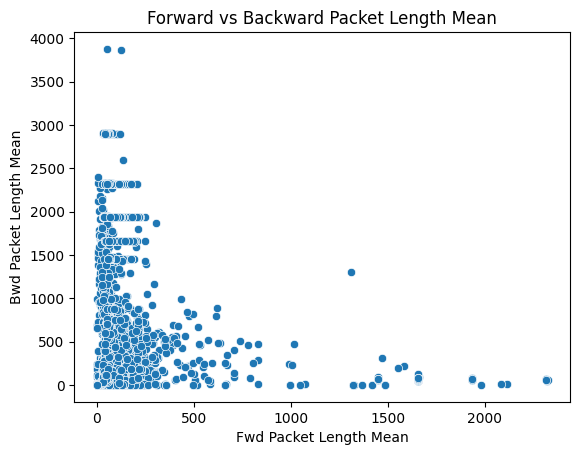

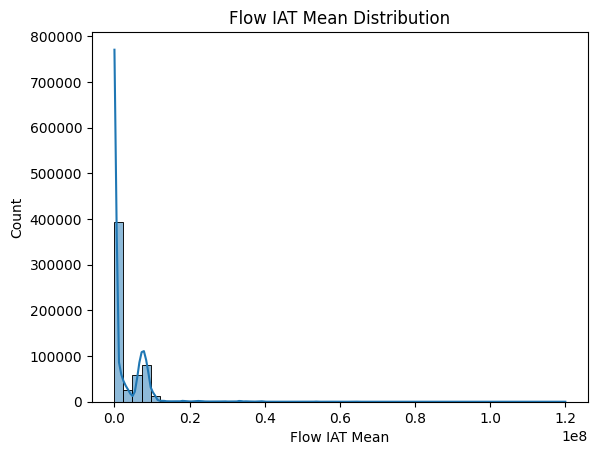

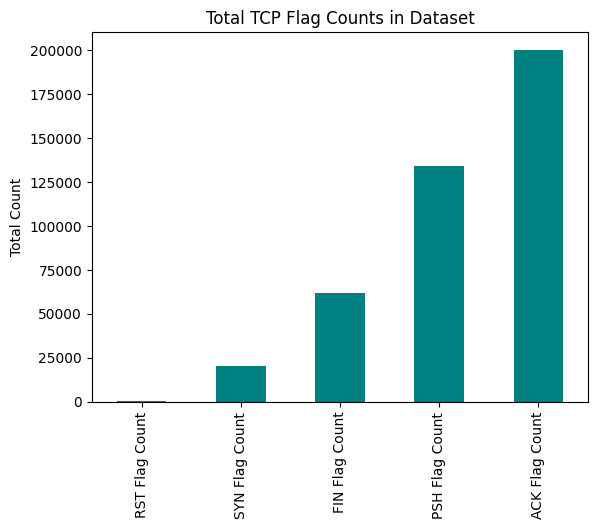

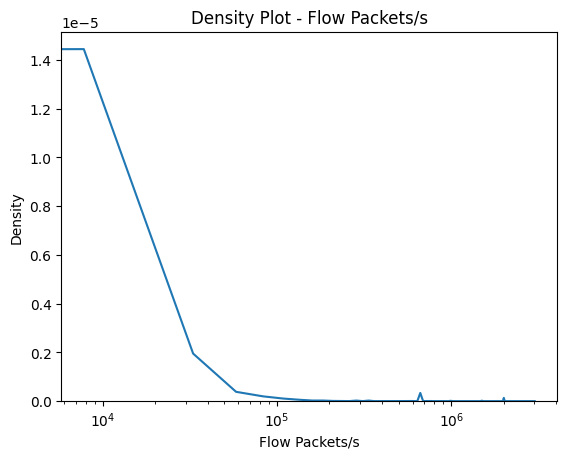

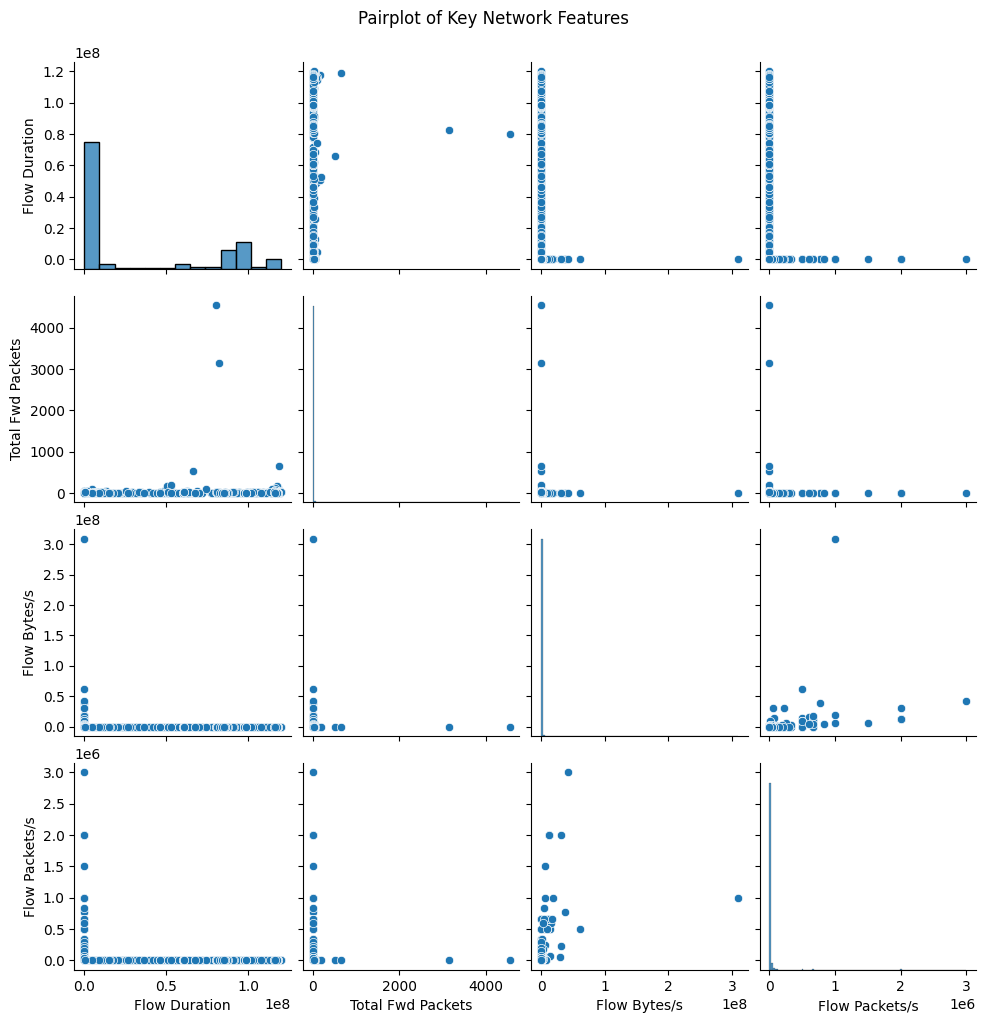

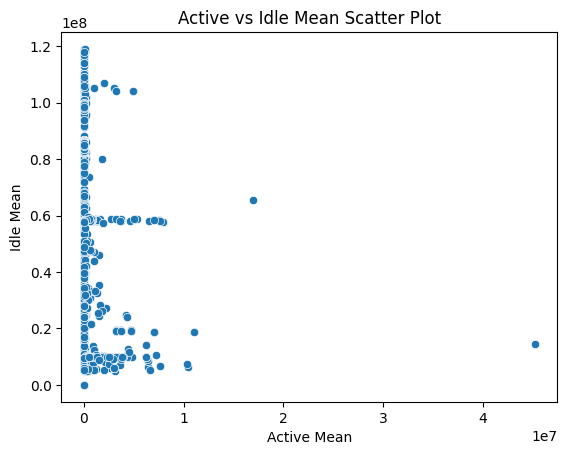

In [5]:
df_features = df

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df_features.corr(numeric_only=True)
sns.heatmap(corr.iloc[:20, :20], cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Top 20 Features)")
plt.show()

# Distribution of Flow Duration
sns.histplot(df_features['Flow Duration'], bins=50, kde=True)
plt.title("Distribution of Flow Duration")
plt.xlabel("Flow Duration (microseconds)")
plt.show()

# Boxplot - Total Forward Packets
sns.boxplot(x=df_features['Total Fwd Packets'])
plt.title("Boxplot - Total Forward Packets")
plt.show()

# -Scatter Plot - Flow Bytes/s vs Flow Packets/s 
sample1 = df_features.sample(10000, random_state=42)
sns.scatterplot(x='Flow Packets/s', y='Flow Bytes/s', data=sample1)
plt.title("Flow Bytes/s vs Flow Packets/s")
plt.xscale('log')
plt.yscale('log')
plt.show()

# Scatter Plot - Fwd vs Bwd Packet Length Mean
sns.scatterplot(x='Fwd Packet Length Mean', y='Bwd Packet Length Mean', data=sample1)
plt.title("Forward vs Backward Packet Length Mean")
plt.show()

# Flow IAT Mean Distribution 
sns.histplot(df_features['Flow IAT Mean'], bins=50, kde=True)
plt.title("Flow IAT Mean Distribution")
plt.show()

# TCP Flag Count Overview 
flag_cols = ['FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 
             'PSH Flag Count', 'ACK Flag Count']
df_flags = df_features[flag_cols]
df_flags.sum().sort_values().plot(kind='bar', color='teal')
plt.title("Total TCP Flag Counts in Dataset")
plt.ylabel("Total Count")
plt.show()

# KDE Plot - Flow Packets/s 
sns.kdeplot(df_features['Flow Packets/s'], bw_adjust=0.5)
plt.title("Density Plot - Flow Packets/s")
plt.xscale('log')
plt.show()

# Pairplot - Selected Features 
sample2 = df_features.sample(3000, random_state=42)
sns.pairplot(sample2[['Flow Duration', 'Total Fwd Packets', 'Flow Bytes/s', 'Flow Packets/s']])
plt.suptitle("Pairplot of Key Network Features", y=1.02)
plt.show()

# Active vs Idle Mean Scatter
sns.scatterplot(x='Active Mean', y='Idle Mean', data=sample1)
plt.title("Active vs Idle Mean Scatter Plot")
plt.show()

In [6]:
le_label = LabelEncoder()
df['Label'] = le_label.fit_transform(df['Label'])  # Benign=0, Attack=1

categorical_cols = ['Protocol']  # rename according to dataset
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

df['byte_ratio'] = df['Fwd Packets Length Total'] / (df['Bwd Packets Length Total'] + 1)

df['count_srv_ratio'] = df['Total Fwd Packets'] / (df['Subflow Fwd Packets'] + 1)

agg_features = df.groupby('Label')[['Flow Duration', 'Fwd Packets Length Total', 'Bwd Packets Length Total']].mean().reset_index()
print("✅ Aggregated Features by Attack Type:")
print(agg_features)



✅ Aggregated Features by Attack Type:
   Label  Flow Duration  Fwd Packets Length Total  Bwd Packets Length Total
0      0   7.263690e+07                394.428493              10032.801730
1      1   1.359780e+07                777.746725              25119.744624


In [7]:
X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/Test Split Completed: \n")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

Train/Test Split Completed: 

X_train shape: (467992, 79)
X_test shape: (116999, 79)
y_train distribution:
 Label
1    312987
0    155005
Name: count, dtype: int64
y_test distribution:
 Label
1    78248
0    38751
Name: count, dtype: int64


### **Standard Scaler**

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


### **SMOTE & Random Forest Classifier**

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

### **Train and Evaluate with Different Models**

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assume X_train_res, y_train_res, X_test_scaled, y_test defined

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9986410140257609

Confusion Matrix:
 [[38676    75]
 [   84 78164]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     38751
           1       1.00      1.00      1.00     78248

    accuracy                           1.00    116999
   macro avg       1.00      1.00      1.00    116999
weighted avg       1.00      1.00      1.00    116999



In [16]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

results = []

# Train and Evaluate each model
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"]
    })
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", report)

df_results = pd.DataFrame(results)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Confusion Matrix:
 [[37603  1148]
 [  970 77278]]

Classification Report:
 {'0': {'precision': 0.9748528763642963, 'recall': 0.9703749580655983, 'f1-score': 0.9726087631265843, 'support': 38751.0}, '1': {'precision': 0.9853619972968148, 'recall': 0.9876035170227994, 'f1-score': 0.986481483845437, 'support': 78248.0}, 'accuracy': 0.9818972811733434, 'macro avg': {'precision': 0.9801074368305556, 'recall': 0.9789892375441989, 'f1-score': 0.9795451234860106, 'support': 116999.0}, 'weighted avg': {'precision': 0.9818812928014258, 'recall': 0.9818972811733434, 'f1-score': 0.9818867283297807, 'support': 116999.0}}

Confusion Matrix:
 [[38712    39]
 [   68 78180]]

Classification Report:
 {'0': {'precision': 0.9982465188241362, 'recall': 0.9989935743593714, 'f1-score': 0.9986199068759593, 'support': 38751.0}, '1': {'precision': 0.9995013999156215, 'recall': 0.9991309682036602, 'f1-score': 0.9993161497312533, 'support': 78248.0}, 'accuracy': 0.9990854622689083, 'macro avg': {'precision': 0.9

/tmp/ipykernel_2780/40705675.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=df_results, palette="Set2")


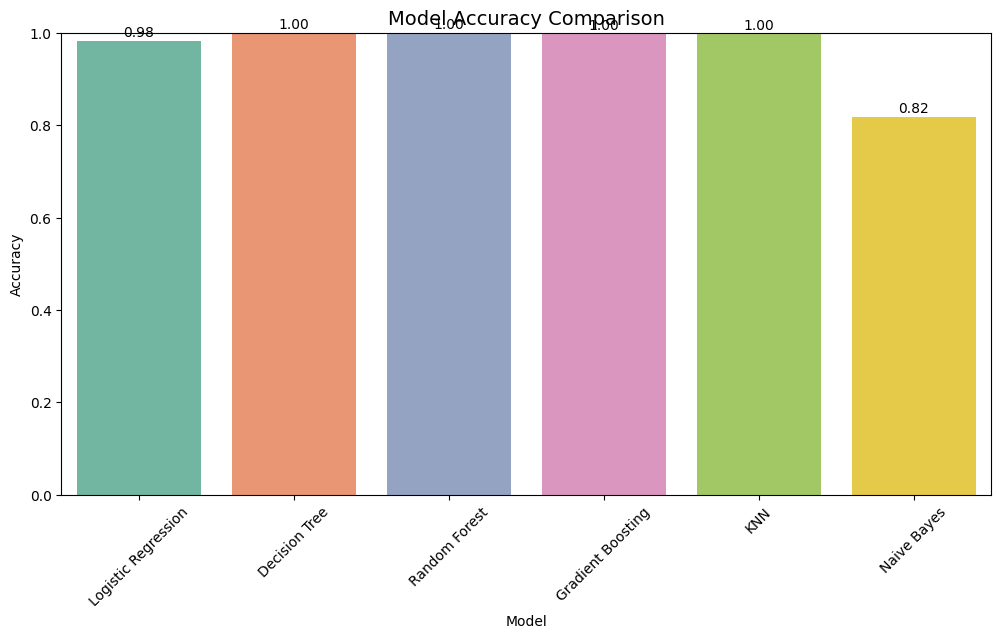

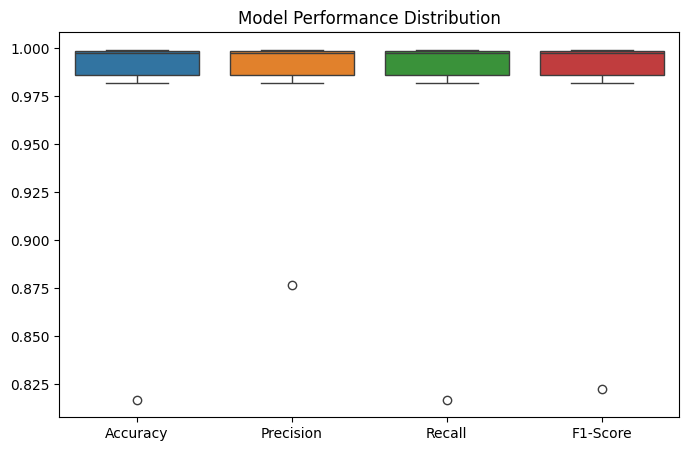

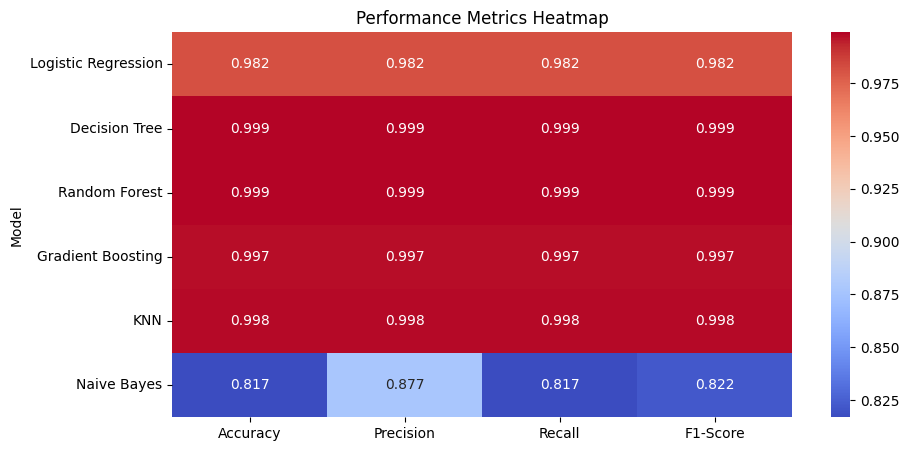

In [18]:
# Accuracy Bar Plot
plt.figure(figsize=(12,6))
sns.barplot(x="Model", y="Accuracy", data=df_results, palette="Set2")
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylim(0,1)
plt.xticks(rotation=45)
for i, v in enumerate(df_results["Accuracy"]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
plt.show()

# Boxplot of Metrics
plt.figure(figsize=(8,5))
sns.boxplot(data=df_results.drop("Model", axis=1))
plt.title("Model Performance Distribution")
plt.show()

# Heatmap of Metrics
plt.figure(figsize=(10,5))
sns.heatmap(df_results.set_index("Model"), annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Performance Metrics Heatmap")
plt.show()

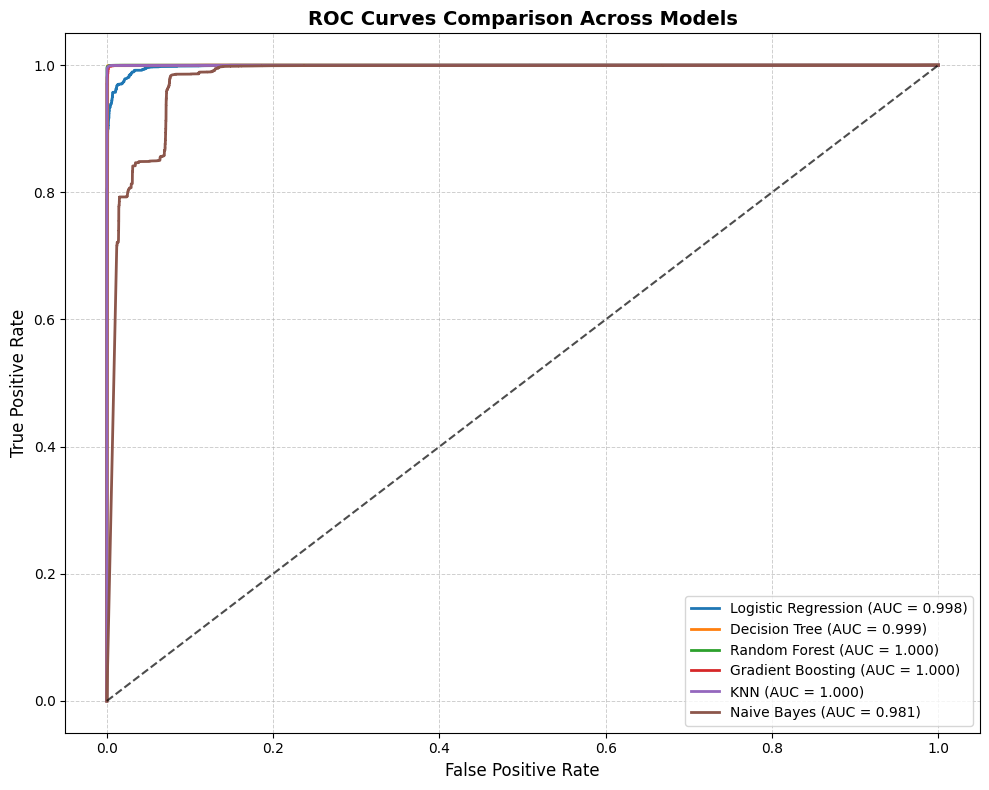

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Compute probability or decision function safely
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test_scaled)
    else:
        print(f"Skipping {name}: no probability or decision_function available.")
        continue

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Reference diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)

# Customize plot
plt.title("ROC Curves Comparison Across Models", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
plt.tight_layout()

# Show the ROC plot
plt.show()
